In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
import tensorflow.compat.v1 as tf

# Disable eager execution for Adversarial Debiasing
tf.disable_eager_execution()

# Display output in notebook
%matplotlib inline

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [7]:
# Load and Explore Dataset
# Load the dataset
file_path = 'project-data.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Display dataset info
print("Dataset Shape:", data.shape)
print("Dataset Columns:", data.columns)
print(data.head())
print(data.isnull().sum())

Dataset Shape: (614, 13)
Dataset Columns: Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2

In [15]:
data_info = {
    "Shape": data.shape,
    "Columns": data.columns.tolist(),
    "Data Types": data.dtypes.to_dict(),
    "Missing Values": data.isnull().sum().to_dict(),
    "First Few Rows": data.head().to_dict()
}

data_info

{'Shape': (614, 13),
 'Columns': ['Loan_ID',
  'Gender',
  'Married',
  'Dependents',
  'Education',
  'Self_Employed',
  'ApplicantIncome',
  'CoapplicantIncome',
  'LoanAmount',
  'Loan_Amount_Term',
  'Credit_History',
  'Property_Area',
  'Loan_Status'],
 'Data Types': {'Loan_ID': dtype('O'),
  'Gender': dtype('int64'),
  'Married': dtype('int64'),
  'Dependents': dtype('int64'),
  'Education': dtype('int64'),
  'Self_Employed': dtype('int64'),
  'ApplicantIncome': dtype('float64'),
  'CoapplicantIncome': dtype('float64'),
  'LoanAmount': dtype('float64'),
  'Loan_Amount_Term': dtype('float64'),
  'Credit_History': dtype('float64'),
  'Property_Area': dtype('int64'),
  'Loan_Status': dtype('int64')},
 'Missing Values': {'Loan_ID': 0,
  'Gender': 0,
  'Married': 0,
  'Dependents': 0,
  'Education': 0,
  'Self_Employed': 0,
  'ApplicantIncome': 0,
  'CoapplicantIncome': 0,
  'LoanAmount': 0,
  'Loan_Amount_Term': 0,
  'Credit_History': 0,
  'Property_Area': 0,
  'Loan_Status': 0},
 '

In [8]:
# Data Cleaning
def clean_data(data):
    """Clean the dataset by handling missing values."""
    data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
    data['Married'].fillna(data['Married'].mode()[0], inplace=True)
    data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
    data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
    data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)
    data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
    data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
    return data

# Clean the dataset
cleaned_data = clean_data(data)

# Display cleaned data info
print("Missing Values After Cleaning:\n", cleaned_data.isnull().sum())

Missing Values After Cleaning:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


/var/folders/v7/_1xlyqvs26z81fbvft3w9tlr0000gn/T/ipykernel_2217/594478303.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
/var/folders/v7/_1xlyqvs26z81fbvft3w9tlr0000gn/T/ipykernel_2217/594478303.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

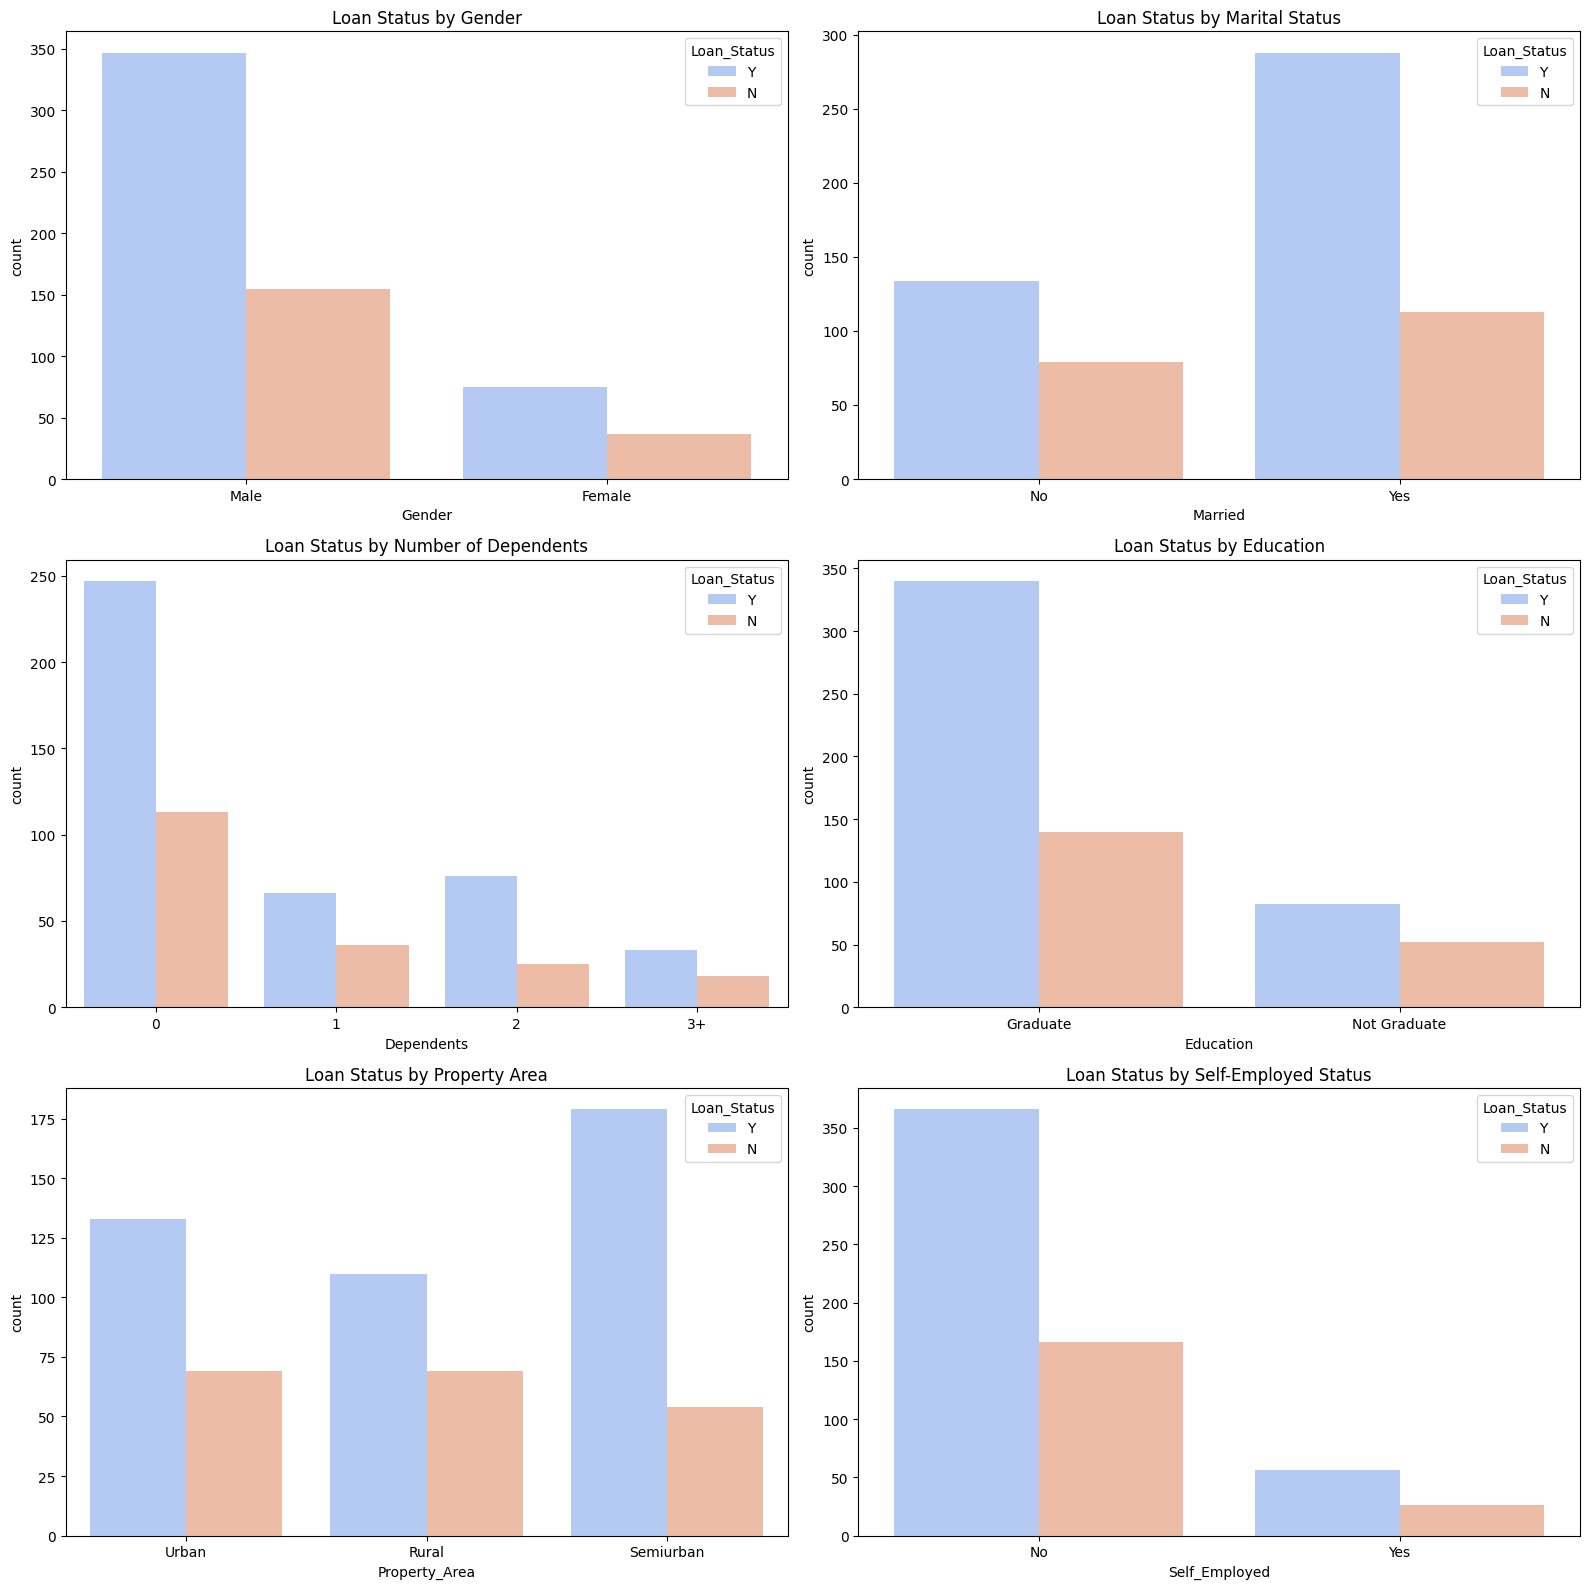

In [9]:
# Data Visualization
def visualize_biases(data):
    """Generate visualizations to highlight potential biases."""
    plt.figure(figsize=(16, 16))
    
    # Gender Distribution
    plt.subplot(3, 2, 1)
    sns.countplot(data=data, x='Gender', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Gender')
    
    # Married Distribution
    plt.subplot(3, 2, 2)
    sns.countplot(data=data, x='Married', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Marital Status')
    
    # Dependents Distribution
    plt.subplot(3, 2, 3)
    sns.countplot(data=data, x='Dependents', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Number of Dependents')
    
    # Education Distribution
    plt.subplot(3, 2, 4)
    sns.countplot(data=data, x='Education', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Education')
    
    # Property Area Distribution
    plt.subplot(3, 2, 5)
    sns.countplot(data=data, x='Property_Area', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Property Area')

    # Self-Employment Status
    plt.subplot(3, 2, 6)
    sns.countplot(data=data, x='Self_Employed', hue='Loan_Status', palette='coolwarm')
    plt.title('Loan Status by Self-Employed Status')
    
    plt.tight_layout()
    plt.show()

# Visualize biases
visualize_biases(cleaned_data)

In [10]:
# Feature Encoding and Normalization
def encode_features(data):
    label_encoders = {}
    for col in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
    return data, label_encoders

def normalize_features(data):
    scaler = MinMaxScaler()
    data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']] = scaler.fit_transform(data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
    return data

# Apply encoding and normalization
encoded_data, label_encoders = encode_features(cleaned_data)
normalized_data = normalize_features(encoded_data)

# Split the dataset
X = normalized_data.drop(columns=['Loan_ID', 'Loan_Status'])
y = normalized_data['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Train Baseline Model
# Train Logistic Regression
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# Evaluate Baseline Model
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline Classification Report:\n", classification_report(y_test, y_pred))

Baseline Accuracy: 0.7837837837837838
Baseline Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.42      0.57        65
           1       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



/Users/harold.g/Library/Caches/pypoetry/virtualenvs/loan-approval-system-with-bias-mitigation-uCPzHwT8-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# Evaluate Fairness of Baseline Model
protected_attribute = 'Gender'

# Convert to AIF360 dataset
train_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                                   label_names=['Loan_Status'],
                                   protected_attribute_names=[protected_attribute])
test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                  label_names=['Loan_Status'],
                                  protected_attribute_names=[protected_attribute])

# Evaluate fairness
metric = BinaryLabelDatasetMetric(test_dataset, privileged_groups=[{protected_attribute: 1}], unprivileged_groups=[{protected_attribute: 0}])
print("Baseline Statistical Parity Difference:", metric.statistical_parity_difference())

Baseline Statistical Parity Difference: -0.13307552320291172


In [13]:
# Bias Mitigation Techniques

# Pre-processing: Reweighing
rw = Reweighing(privileged_groups=[{protected_attribute: 1}], unprivileged_groups=[{protected_attribute: 0}])
rw_train_dataset = rw.fit_transform(train_dataset)

# In-processing: Adversarial Debiasing
sess = tf.Session()
adv_debias = AdversarialDebiasing(privileged_groups=[{protected_attribute: 1}],
                                  unprivileged_groups=[{protected_attribute: 0}],
                                  scope_name='debias',
                                  sess=sess)
adv_debias.fit(rw_train_dataset)
debias_test_dataset = adv_debias.predict(test_dataset)

# Post-processing: Calibrated Equal Odds
ceop = CalibratedEqOddsPostprocessing(privileged_groups=[{protected_attribute: 1}],
                                      unprivileged_groups=[{protected_attribute: 0}])
ceop.fit(test_dataset, debias_test_dataset)
postprocess_test_dataset = ceop.predict(test_dataset)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
I0000 00:00:1733257050.902163 4419647 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 8.929487; batch adversarial loss: 0.514528
epoch 1; iter: 0; batch classifier loss: 9.691568; batch adversarial loss: 0.574793
epoch 2; iter: 0; batch classifier loss: 5.321686; batch adversarial loss: 0.511466
epoch 3; iter: 0; batch classifier loss: 3.236059; batch adversarial loss: 0.584794
epoch 4; iter: 0; batch classifier loss: 6.042967; batch adversarial loss: 0.607996
epoch 5; iter: 0; batch classifier loss: 6.873774; batch adversarial loss: 0.623126
epoch 6; iter: 0; batch classifier loss: 6.721238; batch adversarial loss: 0.635156
epoch 7; iter: 0; batch classifier loss: 5.811110; batch adversarial loss: 0.589015
epoch 8; iter: 0; batch classifier loss: 4.331396; batch adversarial loss: 0.553024
epoch 9; iter: 0; batch classifier loss: 4.171164; batch adversarial loss: 0.564268
epoch 10; iter: 0; batch classifier loss: 5.216051; batch adversarial loss: 0.528179
epoch 11; iter: 0; batch classifier loss: 5.755594; batch adversarial loss:

In [14]:
# Evaluate Fairness After Mitigation
def evaluate_fairness(dataset, description):
    metric = BinaryLabelDatasetMetric(dataset, privileged_groups=[{protected_attribute: 1}], unprivileged_groups=[{protected_attribute: 0}])
    print(f"{description} - Statistical Parity Difference:", metric.statistical_parity_difference())

evaluate_fairness(rw_train_dataset, "Pre-processing Reweighing")
evaluate_fairness(debias_test_dataset, "In-processing Adversarial Debiasing")
evaluate_fairness(postprocess_test_dataset, "Post-processing Equal Odds")

Pre-processing Reweighing - Statistical Parity Difference: 3.3306690738754696e-16
In-processing Adversarial Debiasing - Statistical Parity Difference: 0.0
Post-processing Equal Odds - Statistical Parity Difference: -0.4642857142857143
